<a href="https://colab.research.google.com/github/loki2124/SignSpeak/blob/main/experiments/SignSpeak_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount= True)

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/SignSpeak/MNIST/data/archive.zip'

Archive:  /content/drive/MyDrive/SignSpeak/MNIST/data/archive.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from sklearn.preprocessing import LabelBinarizer

import cv2
import time
import copy

In [4]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [121]:
print('Train size:', len(train))
print('Test size:', len(test))

Train size: 27455
Test size: 7172


In [6]:
unique_labels = np.unique(np.array(train['label'].values))
print(unique_labels)
print(len(unique_labels))

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
24


In [7]:
#updating the labels: decremented labels >= 10 to labels-1  
train['label'] = np.where(train['label'] >= 10, train['label']-1, train['label'])
test['label'] = np.where(test['label'] >= 10, test['label']-1, test['label'])


In [79]:
class MNISTDataset(Dataset):
  def __init__(self, data, transform):

    cols = data.columns
    pixels = [i for i in cols if i != 'label']
    self.pixels = data[pixels].values
    self.data = np.array([np.reshape(i, (28,28)) for i in self.pixels])
    self.labels = np.array(data['label'])

    # label_binrizer = LabelBinarizer()
    # self.labels = label_binrizer.fit_transform(self.labels)

    self.transform=transform
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    
    image = self.data[index]
    image = image/255
    image = torch.Tensor(image)
    image = image.repeat(3,1,1)
    image = self.transform(image)

    targets= self.labels[index]
    
    return image, targets

In [80]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((32, 32)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor()])

test_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((32, 32)),
                transforms.ToTensor()])

train_dataset = MNISTDataset(train,train_transform)
test_dataset = MNISTDataset(test,test_transform)

# Vizualize batches

In [81]:
BATCH_SIZE = 4

train_dataloader = DataLoader(
    train_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [82]:
batch_images, batch_targets = next(iter(train_dataloader))

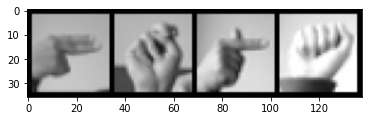

In [83]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
batch_images, batch_targets = next(iter(test_dataloader))

# Make a grid from batch
output = torchvision.utils.make_grid(batch_images)

imshow(output)

In [84]:
batch_images[0].shape

torch.Size([3, 32, 32])

# Model : MobilenetV2

In [85]:
import torchvision.models as models
mobilenet_v2 = models.mobilenet_v2(pretrained=True)


In [86]:
def initialize_model(model, num_classes, feature_extract, use_pretrained=True):
    input_size = 0

    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.classifier[1].in_features
    print('Pretrained model has 1000 classes')
    print('changing the classifier layer to predict {} labels...'.format(num_classes))
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    input_size = 32

    return model, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [87]:
# Initialize the model
model_ft, input_size = initialize_model(mobilenet_v2, num_classes = 24, feature_extract = True, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Pretrained model has 1000 classes
changing the classifier layer to predict 24 labels...
MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, 

# Model: CNN

In [98]:
class Network(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()

        #Conv group 1
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size= (3,3)),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        
        #Max Pooling
        self.maxpool_1 = nn.MaxPool2d(2)

        #Conv group 2
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size= (3,3)),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Dropout2d(0.1)
                                   )
        
        #Max Pooling
        self.maxpool_2 = nn.MaxPool2d(2)

        #Conv group 2
        self.conv3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size= (3,3)),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        
        #Max Pooling
        self.maxpool_3 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()       
        self.cls_layer = nn.Sequential(nn.Linear(256, 128),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(128, num_classes)
                                       )  

    def forward(self, x):

      x = self.conv1(x)
      x = self.maxpool_1(x)
      x = self.conv2(x)
      x = self.maxpool_2(x)
      x = self.conv3(x)
      x = self.maxpool_3(x)
      x = self.flatten(x)
      x = self.cls_layer(x)

      return x

# Dataloaders

In [113]:
BATCH_SIZE = 128
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((32, 32)),
                transforms.RandomHorizontalFlip(p=0.1),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor()]),
    'val': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((32, 32)),
                transforms.ToTensor()]),
}

print("Initializing Datasets and Dataloaders...")

raw_data = {'train': train, 'val': test}

# Create training and validation datasets
image_datasets = {x: MNISTDataset(raw_data[x], data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size= BATCH_SIZE, 
                                  shuffle=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


# Optimizer

In [115]:
# model to GPU
model = Network()
model = model.to(device)

############ For pretrained models #################
# feature_extract = True
# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)
####################################################

# optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=1e-3)
optimizer_ft = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'max', factor = 0.5, patience= 2, threshold= 0.01, verbose = True)

# Training

In [116]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
              scheduler.step(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [117]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs= 50)

Epoch 0/49
----------
train Loss: 1.1199 Acc: 0.6733
val Loss: 0.3980 Acc: 0.9014

Epoch 1/49
----------
train Loss: 0.2290 Acc: 0.9397
val Loss: 0.2363 Acc: 0.9396

Epoch 2/49
----------
train Loss: 0.1125 Acc: 0.9717
val Loss: 0.1731 Acc: 0.9491

Epoch 3/49
----------
train Loss: 0.0761 Acc: 0.9816
val Loss: 0.0830 Acc: 0.9731

Epoch 4/49
----------
train Loss: 0.0581 Acc: 0.9863
val Loss: 0.0759 Acc: 0.9792

Epoch 5/49
----------
train Loss: 0.0488 Acc: 0.9887
val Loss: 0.0834 Acc: 0.9778

Epoch 6/49
----------
train Loss: 0.0411 Acc: 0.9915
val Loss: 0.0629 Acc: 0.9834

Epoch 7/49
----------
train Loss: 0.0359 Acc: 0.9923
val Loss: 0.0679 Acc: 0.9789

Epoch 8/49
----------
train Loss: 0.0373 Acc: 0.9915
val Loss: 0.0822 Acc: 0.9741

Epoch 9/49
----------
train Loss: 0.0346 Acc: 0.9920
val Loss: 0.1649 Acc: 0.9490
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.

Epoch 10/49
----------
train Loss: 0.0217 Acc: 0.9958
val Loss: 0.0677 Acc: 0.9720

Epoch 11/49
----------
t

In [122]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SignSpeak/MNIST/Models/MNIST_CNN')